## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp019b'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext101_32x4d'
    backbone = 'se_resnext50_32x4d'

    in_chans = 8 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-6 / warmup_factor

    # ============== fold =============
    valid_id = 2 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [ #https://www.kaggle.com/competitions/hubmap-kidney-segmentation/discussion/238013
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9,
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.ElasticTransform(p=.3),
            A.GaussianBlur(p=.3),
            A.GaussNoise(p=.3),
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3,p=0.3),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:299: FutureWarning: This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead
  warnings.warn("This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead", FutureWarning)


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list,p=1.0)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list,p=1.0)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([8, 224, 224])

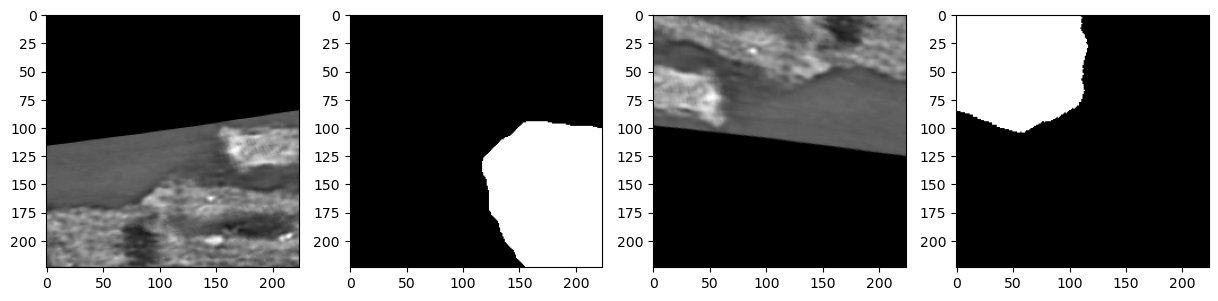

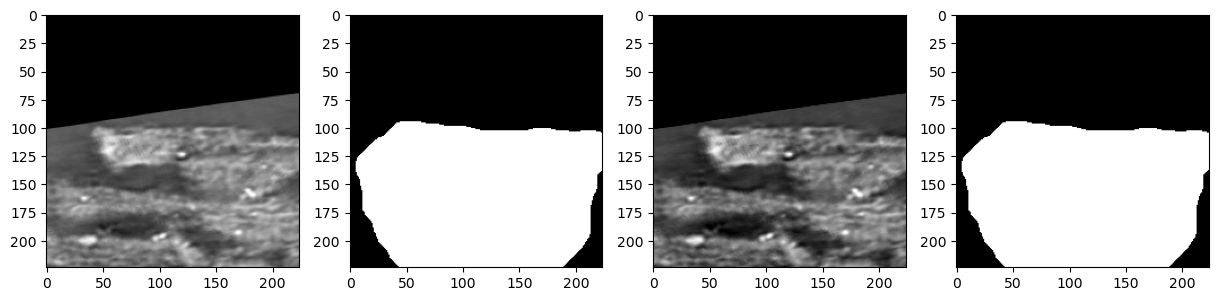

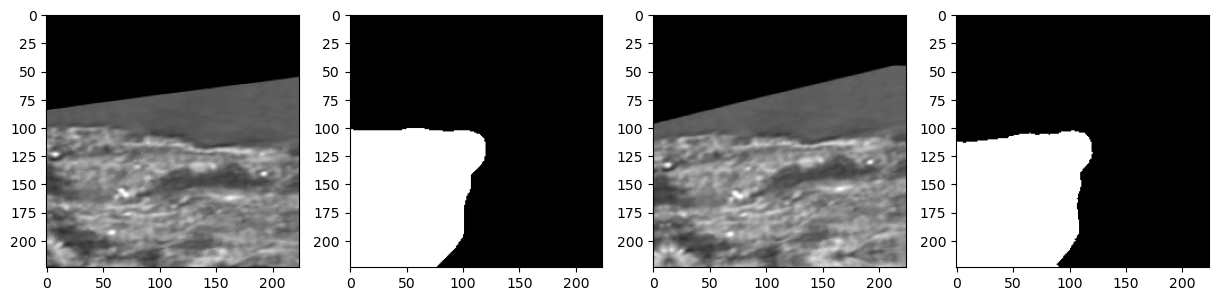

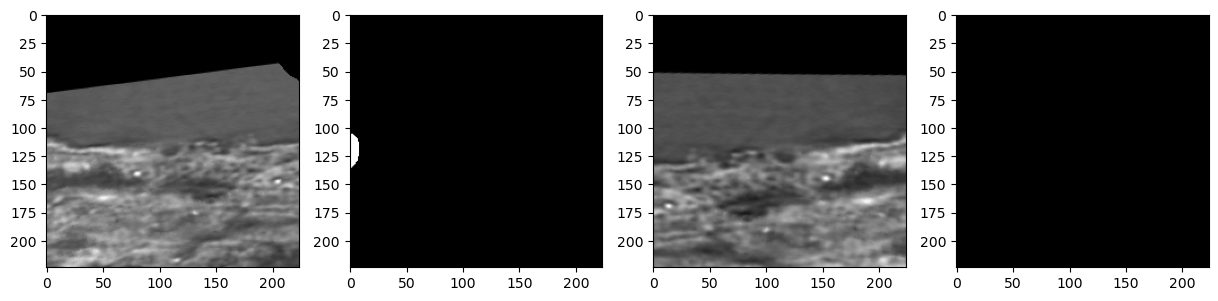

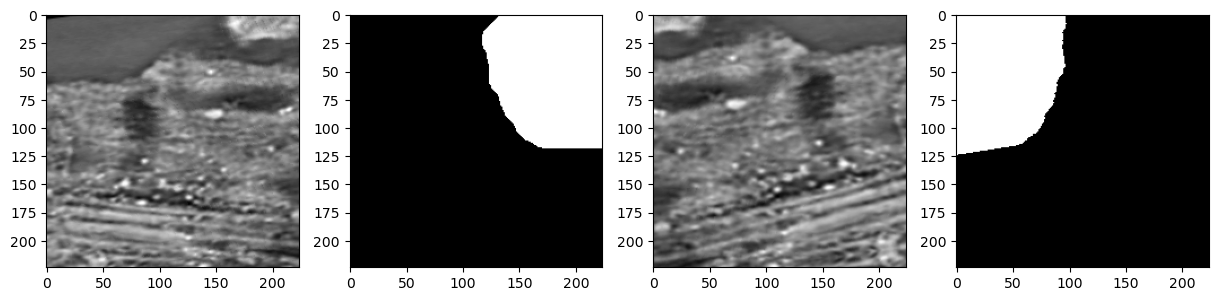

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48115

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext50_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.142006583688151
th: 0.15, fbeta: 0.14178546938592324
th: 0.2, fbeta: 0.14126406387024654
th: 0.25, fbeta: 0.1402686189513858
th: 0.3, fbeta: 0.13861008434183364
th: 0.35, fbeta: 0.13607147175132261
th: 0.4, fbeta: 0.1324604681274417
th: 0.45, fbeta: 0.12874159659209333


best_th: 0.1, fbeta: 0.142006583688151
Epoch 1 - avg_train_loss: 0.8641  avg_val_loss: 0.8440  time: 121s
Epoch 1 - avgScore: 0.1420
Epoch 1 - Save Best Score: 0.1420 Model
Epoch 1 - Save Best Loss: 0.8440 Model


th: 0.5, fbeta: 0.1289534318485985


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.14204203499978035
th: 0.15, fbeta: 0.14190800730212993
th: 0.2, fbeta: 0.14157548487430047
th: 0.25, fbeta: 0.14089075890756575
th: 0.3, fbeta: 0.1396743608230918
th: 0.35, fbeta: 0.1377354530709417
th: 0.4, fbeta: 0.1350093416107668
th: 0.45, fbeta: 0.13242684730169554


best_th: 0.5, fbeta: 0.14430637990002979
Epoch 2 - avg_train_loss: 0.8540  avg_val_loss: 0.8487  time: 119s
Epoch 2 - avgScore: 0.1443
Epoch 2 - Save Best Score: 0.1443 Model
Epoch 2 - Save Best Loss: 0.8487 Model


th: 0.5, fbeta: 0.14430637990002979


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.1420547571230466
th: 0.15, fbeta: 0.14194635175594547
th: 0.2, fbeta: 0.14166553562157053
th: 0.25, fbeta: 0.14107639251899898
th: 0.3, fbeta: 0.14003171841037423
th: 0.35, fbeta: 0.13865103396847406
th: 0.4, fbeta: 0.13950941070519174
th: 0.45, fbeta: 0.18535748262023213


best_th: 0.5, fbeta: 0.20126709378975938
Epoch 3 - avg_train_loss: 0.8203  avg_val_loss: 0.7980  time: 121s
Epoch 3 - avgScore: 0.2013
Epoch 3 - Save Best Score: 0.2013 Model
Epoch 3 - Save Best Loss: 0.7980 Model


th: 0.5, fbeta: 0.20126709378975938


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.14207334217483814
th: 0.15, fbeta: 0.14200924174888546
th: 0.2, fbeta: 0.1418254337986456
th: 0.25, fbeta: 0.14139512663488094
th: 0.3, fbeta: 0.14057945168356942
th: 0.35, fbeta: 0.14052602830917163
th: 0.4, fbeta: 0.1827517730600568
th: 0.45, fbeta: 0.2009417472907008


best_th: 0.5, fbeta: 0.2087692062687222
Epoch 4 - avg_train_loss: 0.7756  avg_val_loss: 0.7556  time: 123s
Epoch 4 - avgScore: 0.2088
Epoch 4 - Save Best Score: 0.2088 Model
Epoch 4 - Save Best Loss: 0.7556 Model


th: 0.5, fbeta: 0.2087692062687222


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.14207777325974902
th: 0.15, fbeta: 0.14202103436629723
th: 0.2, fbeta: 0.1418350790669516
th: 0.25, fbeta: 0.14137169612767705
th: 0.3, fbeta: 0.14045538242753847
th: 0.35, fbeta: 0.14294979081998238
th: 0.4, fbeta: 0.19147799432270138
th: 0.45, fbeta: 0.2070405617749877


best_th: 0.5, fbeta: 0.21407129753751158
Epoch 5 - avg_train_loss: 0.7399  avg_val_loss: 0.7096  time: 124s
Epoch 5 - avgScore: 0.2141
Epoch 5 - Save Best Score: 0.2141 Model
Epoch 5 - Save Best Loss: 0.7096 Model


th: 0.5, fbeta: 0.21407129753751158


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.14208280035557466
th: 0.15, fbeta: 0.14203696651652428
th: 0.2, fbeta: 0.14188299939949175
th: 0.25, fbeta: 0.1414721087962067
th: 0.3, fbeta: 0.14064873514127563
th: 0.35, fbeta: 0.14583471106877757
th: 0.4, fbeta: 0.19609402421460895
th: 0.45, fbeta: 0.21073277789892622


best_th: 0.5, fbeta: 0.21834848589304232
Epoch 6 - avg_train_loss: 0.7079  avg_val_loss: 0.6964  time: 125s
Epoch 6 - avgScore: 0.2183
Epoch 6 - Save Best Score: 0.2183 Model
Epoch 6 - Save Best Loss: 0.6964 Model


th: 0.5, fbeta: 0.21834848589304232


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.14208709825100233
th: 0.15, fbeta: 0.14205415771901295
th: 0.2, fbeta: 0.14192902579887007
th: 0.25, fbeta: 0.14156128904649973
th: 0.3, fbeta: 0.14140849615761697
th: 0.35, fbeta: 0.18742405562077405
th: 0.4, fbeta: 0.20543823659886742
th: 0.45, fbeta: 0.21473697306403947


best_th: 0.5, fbeta: 0.22348273583503056
Epoch 7 - avg_train_loss: 0.6773  avg_val_loss: 0.6440  time: 125s
Epoch 7 - avgScore: 0.2235
Epoch 7 - Save Best Score: 0.2235 Model
Epoch 7 - Save Best Loss: 0.6440 Model


th: 0.5, fbeta: 0.22348273583503056


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.1420853828714679
th: 0.15, fbeta: 0.1420496380900636
th: 0.2, fbeta: 0.1419106704263088
th: 0.25, fbeta: 0.1414961093527589
th: 0.3, fbeta: 0.1439164459242439
th: 0.35, fbeta: 0.19487816259071597
th: 0.4, fbeta: 0.20861216066293192
th: 0.45, fbeta: 0.2191118155795902


best_th: 0.5, fbeta: 0.22661689319181677
Epoch 8 - avg_train_loss: 0.6464  avg_val_loss: 0.6053  time: 125s
Epoch 8 - avgScore: 0.2266
Epoch 8 - Save Best Score: 0.2266 Model
Epoch 8 - Save Best Loss: 0.6053 Model


th: 0.5, fbeta: 0.22661689319181677


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.14208301874152907
th: 0.15, fbeta: 0.14203834105276977
th: 0.2, fbeta: 0.14187709339620178
th: 0.25, fbeta: 0.14137839562865134
th: 0.3, fbeta: 0.16551345102606604
th: 0.35, fbeta: 0.1976784694842017
th: 0.4, fbeta: 0.2116698493121721
th: 0.45, fbeta: 0.22345632729748366


best_th: 0.5, fbeta: 0.2318071693546423
Epoch 9 - avg_train_loss: 0.6142  avg_val_loss: 0.5772  time: 121s
Epoch 9 - avgScore: 0.2318
Epoch 9 - Save Best Score: 0.2318 Model
Epoch 9 - Save Best Loss: 0.5772 Model


th: 0.5, fbeta: 0.2318071693546423


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.1420789939796481
th: 0.15, fbeta: 0.14202499286415407
th: 0.2, fbeta: 0.14183654814484176
th: 0.25, fbeta: 0.14124582775029168
th: 0.3, fbeta: 0.17117492175866034
th: 0.35, fbeta: 0.19922991915282573
th: 0.4, fbeta: 0.21114782952079972
th: 0.45, fbeta: 0.22317287221078463


best_th: 0.5, fbeta: 0.23051681671518912
Epoch 10 - avg_train_loss: 0.5868  avg_val_loss: 0.5654  time: 120s
Epoch 10 - avgScore: 0.2305


th: 0.5, fbeta: 0.23051681671518912


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.14208457445786032
th: 0.15, fbeta: 0.14204793458759807
th: 0.2, fbeta: 0.14190956520966133
th: 0.25, fbeta: 0.1421162873563105
th: 0.3, fbeta: 0.1901047225713519
th: 0.35, fbeta: 0.20913810046629938
th: 0.4, fbeta: 0.22451980536489877
th: 0.45, fbeta: 0.23795503759314757


best_th: 0.5, fbeta: 0.2497248781240165
Epoch 11 - avg_train_loss: 0.5651  avg_val_loss: 0.5342  time: 121s
Epoch 11 - avgScore: 0.2497
Epoch 11 - Save Best Score: 0.2497 Model
Epoch 11 - Save Best Loss: 0.5342 Model


th: 0.5, fbeta: 0.2497248781240165


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.1420834168527081
th: 0.15, fbeta: 0.1420432060305637
th: 0.2, fbeta: 0.14187400529146924
th: 0.25, fbeta: 0.14188165154187388
th: 0.3, fbeta: 0.19070271769502786
th: 0.35, fbeta: 0.2106399050322771
th: 0.4, fbeta: 0.22505834099375374
th: 0.45, fbeta: 0.23596201616109352


best_th: 0.5, fbeta: 0.24129084690512792
Epoch 12 - avg_train_loss: 0.5456  avg_val_loss: 0.5174  time: 127s
Epoch 12 - avgScore: 0.2413


th: 0.5, fbeta: 0.24129084690512792


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.14208310291722645
th: 0.15, fbeta: 0.14204160536445146
th: 0.2, fbeta: 0.1418691640798474
th: 0.25, fbeta: 0.14156105577647926
th: 0.3, fbeta: 0.19082385004373364
th: 0.35, fbeta: 0.20991222332024356
th: 0.4, fbeta: 0.2274652773158434
th: 0.45, fbeta: 0.24231761858977038


best_th: 0.5, fbeta: 0.24962285596551895
Epoch 13 - avg_train_loss: 0.5298  avg_val_loss: 0.5158  time: 126s
Epoch 13 - avgScore: 0.2496


th: 0.5, fbeta: 0.24962285596551895


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.14208520923076326
th: 0.15, fbeta: 0.14205213882945494
th: 0.2, fbeta: 0.14190266456385517
th: 0.25, fbeta: 0.14474862590795834
th: 0.3, fbeta: 0.19909114305876163
th: 0.35, fbeta: 0.21898614444240486
th: 0.4, fbeta: 0.2349662675581398
th: 0.45, fbeta: 0.24872399128819894


best_th: 0.5, fbeta: 0.24896002828216157
Epoch 14 - avg_train_loss: 0.5161  avg_val_loss: 0.4947  time: 126s
Epoch 14 - avgScore: 0.2490


th: 0.5, fbeta: 0.24896002828216157


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.14208593725699817
th: 0.15, fbeta: 0.14205415822671574
th: 0.2, fbeta: 0.1419123312562436
th: 0.25, fbeta: 0.14638174751641866
th: 0.3, fbeta: 0.2011938672960502
th: 0.35, fbeta: 0.22243372404983588
th: 0.4, fbeta: 0.23895579064183786
th: 0.45, fbeta: 0.2525628600007552


best_th: 0.45, fbeta: 0.2525628600007552
Epoch 15 - avg_train_loss: 0.5049  avg_val_loss: 0.4852  time: 127s
Epoch 15 - avgScore: 0.2526
Epoch 15 - Save Best Score: 0.2526 Model
Epoch 15 - Save Best Loss: 0.4852 Model


th: 0.5, fbeta: 0.2472542535559294


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.14208777191422778
th: 0.15, fbeta: 0.14206088868299124
th: 0.2, fbeta: 0.1419369960926693
th: 0.25, fbeta: 0.1558178880631999
th: 0.3, fbeta: 0.2026417141432936
th: 0.35, fbeta: 0.2253422090988928
th: 0.4, fbeta: 0.24348531257767211
th: 0.45, fbeta: 0.2558121353789362


best_th: 0.45, fbeta: 0.2558121353789362
Epoch 16 - avg_train_loss: 0.4938  avg_val_loss: 0.4781  time: 127s
Epoch 16 - avgScore: 0.2558
Epoch 16 - Save Best Score: 0.2558 Model
Epoch 16 - Save Best Loss: 0.4781 Model


th: 0.5, fbeta: 0.24446762260657873


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.14208856972259412
th: 0.15, fbeta: 0.14206501645635417
th: 0.2, fbeta: 0.14197580965787937
th: 0.25, fbeta: 0.18252664355116827
th: 0.3, fbeta: 0.2059570862724961
th: 0.35, fbeta: 0.22873661028455622
th: 0.4, fbeta: 0.24712284088968792
th: 0.45, fbeta: 0.25283796298105843


best_th: 0.45, fbeta: 0.25283796298105843
Epoch 17 - avg_train_loss: 0.4845  avg_val_loss: 0.4682  time: 127s
Epoch 17 - avgScore: 0.2528


th: 0.5, fbeta: 0.2278351461752168


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.1420886340013396
th: 0.15, fbeta: 0.1420633599510215
th: 0.2, fbeta: 0.14198895659193467
th: 0.25, fbeta: 0.18722503601259313
th: 0.3, fbeta: 0.20632129646231415
th: 0.35, fbeta: 0.2307510167333859
th: 0.4, fbeta: 0.25571930911655955
th: 0.45, fbeta: 0.2708792817119793


best_th: 0.45, fbeta: 0.2708792817119793
Epoch 18 - avg_train_loss: 0.4773  avg_val_loss: 0.4662  time: 126s
Epoch 18 - avgScore: 0.2709
Epoch 18 - Save Best Score: 0.2709 Model
Epoch 18 - Save Best Loss: 0.4662 Model


th: 0.5, fbeta: 0.25650256444344915


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.14208978898837035
th: 0.15, fbeta: 0.14206910884787308
th: 0.2, fbeta: 0.1421254611516389
th: 0.25, fbeta: 0.18946330452324345
th: 0.3, fbeta: 0.2116200808839905
th: 0.35, fbeta: 0.23591658250340156
th: 0.4, fbeta: 0.25953870733210604
th: 0.45, fbeta: 0.26537767298904935


best_th: 0.45, fbeta: 0.26537767298904935
Epoch 19 - avg_train_loss: 0.4697  avg_val_loss: 0.4577  time: 127s
Epoch 19 - avgScore: 0.2654


th: 0.5, fbeta: 0.23462867448047528


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.14208950988194663
th: 0.15, fbeta: 0.14206628619395917
th: 0.2, fbeta: 0.14203425663404393
th: 0.25, fbeta: 0.18979778749883128
th: 0.3, fbeta: 0.21522619414761285
th: 0.35, fbeta: 0.2406798755759186
th: 0.4, fbeta: 0.26692365041046434
th: 0.45, fbeta: 0.269339345294075


best_th: 0.45, fbeta: 0.269339345294075
Epoch 20 - avg_train_loss: 0.4641  avg_val_loss: 0.4526  time: 127s
Epoch 20 - avgScore: 0.2693


th: 0.5, fbeta: 0.23346832965494707


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.1420897077460586
th: 0.15, fbeta: 0.14206779149246604
th: 0.2, fbeta: 0.14232054883913292
th: 0.25, fbeta: 0.19326211993074188
th: 0.3, fbeta: 0.21611062578206444
th: 0.35, fbeta: 0.23927602824956615
th: 0.4, fbeta: 0.2644563555975176
th: 0.45, fbeta: 0.26327226554538713


best_th: 0.4, fbeta: 0.2644563555975176
Epoch 21 - avg_train_loss: 0.4575  avg_val_loss: 0.4497  time: 126s
Epoch 21 - avgScore: 0.2645


th: 0.5, fbeta: 0.22413816473167475


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.14209056226053443
th: 0.15, fbeta: 0.1420683620601728
th: 0.2, fbeta: 0.14193426752618482
th: 0.25, fbeta: 0.18670025189261877
th: 0.3, fbeta: 0.21629184065598375
th: 0.35, fbeta: 0.24086689562762506
th: 0.4, fbeta: 0.26356222477803126
th: 0.45, fbeta: 0.25257983384816424


best_th: 0.4, fbeta: 0.26356222477803126
Epoch 22 - avg_train_loss: 0.4543  avg_val_loss: 0.4494  time: 126s
Epoch 22 - avgScore: 0.2636


th: 0.5, fbeta: 0.20525842373289535


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.14208960307468327
th: 0.15, fbeta: 0.14206901286072748
th: 0.2, fbeta: 0.14238614315134024
th: 0.25, fbeta: 0.1939059404661858
th: 0.3, fbeta: 0.21929144437309883
th: 0.35, fbeta: 0.24037895622142127
th: 0.4, fbeta: 0.25996143673444116
th: 0.45, fbeta: 0.24131729629549376


best_th: 0.4, fbeta: 0.25996143673444116
Epoch 23 - avg_train_loss: 0.4493  avg_val_loss: 0.4448  time: 126s
Epoch 23 - avgScore: 0.2600


th: 0.5, fbeta: 0.18788232556454426


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.14209066455078614
th: 0.15, fbeta: 0.14207238245203266
th: 0.2, fbeta: 0.14234759799035712
th: 0.25, fbeta: 0.19505229470189595
th: 0.3, fbeta: 0.2213044315612846
th: 0.35, fbeta: 0.24691919275990915
th: 0.4, fbeta: 0.27005585638253554
th: 0.45, fbeta: 0.25507164471578886


best_th: 0.4, fbeta: 0.27005585638253554
Epoch 24 - avg_train_loss: 0.4460  avg_val_loss: 0.4420  time: 127s
Epoch 24 - avgScore: 0.2701


th: 0.5, fbeta: 0.2044450935139452


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.14209100242229533
th: 0.15, fbeta: 0.14207862387234002
th: 0.2, fbeta: 0.14253371749695307
th: 0.25, fbeta: 0.196820439383901
th: 0.3, fbeta: 0.22521784501855618
th: 0.35, fbeta: 0.2554359847720626
th: 0.4, fbeta: 0.2880938759618691
th: 0.45, fbeta: 0.284727464943985


best_th: 0.4, fbeta: 0.2880938759618691
Epoch 25 - avg_train_loss: 0.4416  avg_val_loss: 0.4395  time: 126s
Epoch 25 - avgScore: 0.2881
Epoch 25 - Save Best Score: 0.2881 Model
Epoch 25 - Save Best Loss: 0.4395 Model


th: 0.5, fbeta: 0.2432021626540644


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.1420911019633797
th: 0.15, fbeta: 0.14207594756414077
th: 0.2, fbeta: 0.14253034334162598
th: 0.25, fbeta: 0.19808212789995006
th: 0.3, fbeta: 0.22804546513445165
th: 0.35, fbeta: 0.2571656514589393
th: 0.4, fbeta: 0.28514579978084875
th: 0.45, fbeta: 0.2717942498665225


best_th: 0.4, fbeta: 0.28514579978084875
Epoch 26 - avg_train_loss: 0.4394  avg_val_loss: 0.4366  time: 128s
Epoch 26 - avgScore: 0.2851


th: 0.5, fbeta: 0.22339346974714583


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.14209105654003518
th: 0.15, fbeta: 0.14207244088743082
th: 0.2, fbeta: 0.14233196140351026
th: 0.25, fbeta: 0.19673211477488398
th: 0.3, fbeta: 0.22695953759187074
th: 0.35, fbeta: 0.2536600052554609
th: 0.4, fbeta: 0.2729048144097835
th: 0.45, fbeta: 0.24653556794942802


best_th: 0.4, fbeta: 0.2729048144097835
Epoch 27 - avg_train_loss: 0.4378  avg_val_loss: 0.4370  time: 128s
Epoch 27 - avgScore: 0.2729


th: 0.5, fbeta: 0.19131688509529896


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.14209095438518005
th: 0.15, fbeta: 0.14207515746305807
th: 0.2, fbeta: 0.14239883147572313
th: 0.25, fbeta: 0.19552749587699927
th: 0.3, fbeta: 0.22036042709149517
th: 0.35, fbeta: 0.2517746564953408
th: 0.4, fbeta: 0.28373230694341767
th: 0.45, fbeta: 0.2793692691143119


best_th: 0.4, fbeta: 0.28373230694341767
Epoch 28 - avg_train_loss: 0.4349  avg_val_loss: 0.4424  time: 127s
Epoch 28 - avgScore: 0.2837


th: 0.5, fbeta: 0.23642826930071675


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.14209096368811056
th: 0.15, fbeta: 0.14207734134707978
th: 0.2, fbeta: 0.14247159748174207
th: 0.25, fbeta: 0.19535988650532224
th: 0.3, fbeta: 0.22005773237764226
th: 0.35, fbeta: 0.2486857917256824
th: 0.4, fbeta: 0.27482885127730566
th: 0.45, fbeta: 0.2612247846210033


best_th: 0.4, fbeta: 0.27482885127730566
Epoch 29 - avg_train_loss: 0.4338  avg_val_loss: 0.4407  time: 127s
Epoch 29 - avgScore: 0.2748


th: 0.5, fbeta: 0.2121897407312842


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.1420909441644879
th: 0.15, fbeta: 0.14208116849551436
th: 0.2, fbeta: 0.14270794694432623
th: 0.25, fbeta: 0.19750638120989553
th: 0.3, fbeta: 0.22670744889554395
th: 0.35, fbeta: 0.2577297616937736
th: 0.4, fbeta: 0.2885881094295573
th: 0.45, fbeta: 0.27718780469924414


best_th: 0.4, fbeta: 0.2885881094295573
Epoch 30 - avg_train_loss: 0.4342  avg_val_loss: 0.4361  time: 126s
Epoch 30 - avgScore: 0.2886
Epoch 30 - Save Best Score: 0.2886 Model
Epoch 30 - Save Best Loss: 0.4361 Model


th: 0.5, fbeta: 0.23037954223045198


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.1420909441644879
th: 0.15, fbeta: 0.14208116849551436
th: 0.2, fbeta: 0.14270794694432623
th: 0.25, fbeta: 0.19750638120989553
th: 0.3, fbeta: 0.22670744889554395
th: 0.35, fbeta: 0.2577297616937736
th: 0.4, fbeta: 0.2885881094295573
th: 0.45, fbeta: 0.27718780469924414


best_th: 0.4, fbeta: 0.2885881094295573


th: 0.5, fbeta: 0.23037954223045198


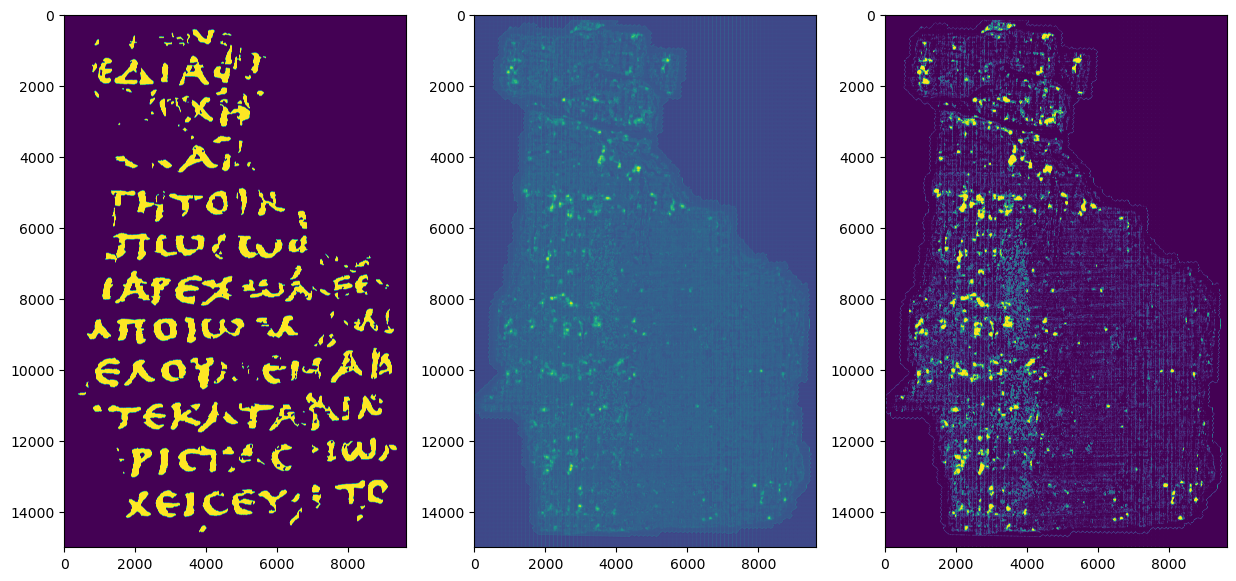

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([7.4000000e+02, 1.0852000e+04, 8.3036000e+04, 1.9782950e+06,
        5.0166042e+07, 3.8764414e+07, 2.9559144e+07, 1.4480216e+07,
        5.1539200e+06, 2.0290090e+06, 1.0097530e+06, 5.5096200e+05,
        3.1775400e+05, 1.8911800e+05, 1.1225700e+05, 7.1184000e+04,
        4.3112000e+04, 2.2361000e+04, 1.1291000e+04, 3.5960000e+03]),
 array([0.0165864 , 0.06512056, 0.11365473, 0.16218889, 0.21072306,
        0.25925722, 0.30779139, 0.35632555, 0.40485972, 0.45339388,
        0.50192805, 0.55046221, 0.59899638, 0.64753054, 0.69606471,
        0.74459887, 0.79313304, 0.8416672 , 0.89020137, 0.93873553,
        0.9872697 ]),
 <BarContainer object of 20 artists>)

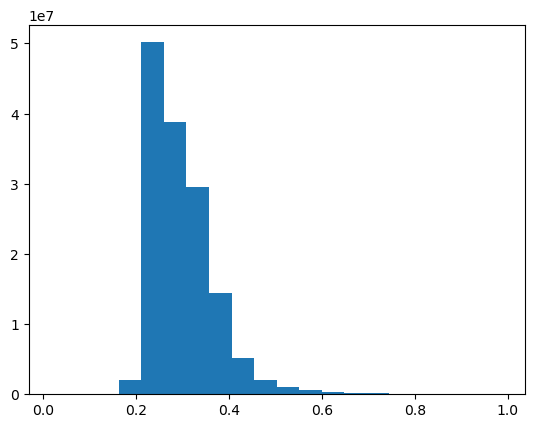

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000